# Predictive maintenance using machine learning
**Author:** Yohannes Kewani Gebrewahid 

## Project Overview
This notebook applies machine learning techniques to the **AI4I 2020 Predictive 
Maintenance Dataset**, which contains simulated sensor readings for industrial 
equipment. The dataset includes variables such as air temperature, process 
temperature, rotational speed, torque, and tool wear, along with labels 
indicating equipment failure modes.  

The main objective is to build models that can predict equipment failures 
before they happen. This supports **Industry 4.0** and **Industrial Analytics** 
by enabling data-driven maintenance planning, reducing downtime, and improving 
system efficiency.  

The notebook covers:
- Data preprocessing and exploratory analysis  
- Feature engineering  
- Training and evaluation of classification models  
- Insights on predictive maintenance for industrial systems


## Importing the required Libraries

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Importing the dataset and Preview

In [4]:

df = pd.read_csv("../data/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Dataset Columns  

- **UDI**: Unique identifier for each record (not useful for prediction).  
- **Product ID**: Product code (categorical, may not directly indicate failures).  
- **Type**: Type of machine (categorical: L, M, H).  
- **Air temperature [K]**: Ambient air temperature around the machine.  
- **Process temperature [K]**: Internal temperature of the process.  
- **Rotational speed [rpm]**: Speed of the machine in revolutions per minute.  
- **Torque [Nm]**: Torque applied to the machine.  
- **Tool wear [min]**: Cumulative time a tool has been in use.  
- **Machine failure**: Target variable (1 = Failure, 0 = No Failure).  
- **TWF, HDF, PWF, OSF, RNF**: Specific types of failures (can be ignored if focusing only on `Machine failure`).  


## Exploratory Data Analysis (EDA) 🔍

### Target Variable Distribution  

The dataset is **imbalanced** — most machines did not fail (`0`), while only a small fraction failed (`1`).  
This imbalance should be considered during model training, as it may affect the performance of classifiers.  


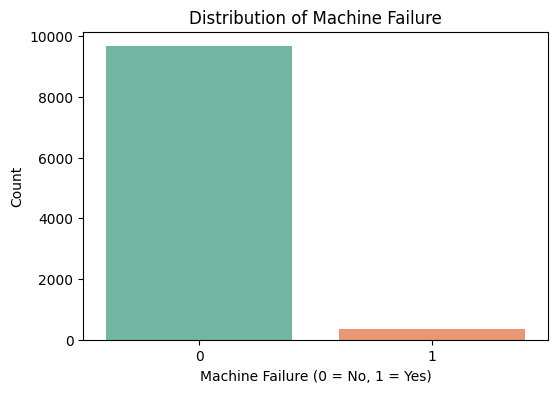

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x="Machine failure", hue="Machine failure", data=df, palette="Set2", legend=False)
plt.title("Distribution of Machine Failure")
plt.xlabel("Machine Failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


## Feature Distributions

In this section, we explore the distributions of the numeric and categorical features in the dataset. Understanding these distributions helps to identify patterns, potential outliers, and relationships between features and the target variable (`Machine failure`).

### Numeric Features
The numeric features include:
- **Air temperature [K]**: Ambient air temperature around the machine.
- **Process temperature [K]**: Temperature of the machine’s internal process.
- **Rotational speed [rpm]**: Machine speed in revolutions per minute.
- **Torque [Nm]**: Torque applied during operation.
- **Tool wear [min]**: Cumulative time the tool has been in use.

We visualize histograms to understand how the data is distributed, identify skewness, and detect potential outliers. Additionally, boxplots comparing these numeric features against `Machine failure` help to highlight which features differ significantly between failed and non-failed machines.

### Categorical Features
The main categorical feature is:
- **Type**: Machine type (L, M, H).

A bar chart is used to show the distribution of different machine types, which allows us to see whether certain types are more prone to failure.

### Insights
From the distributions, we can:
- Detect skewed or unevenly distributed features that may need transformation or normalization.
- Identify outliers that could affect model performance.
- Understand which features are most likely to influence `Machine failure` and may be strong predictors.


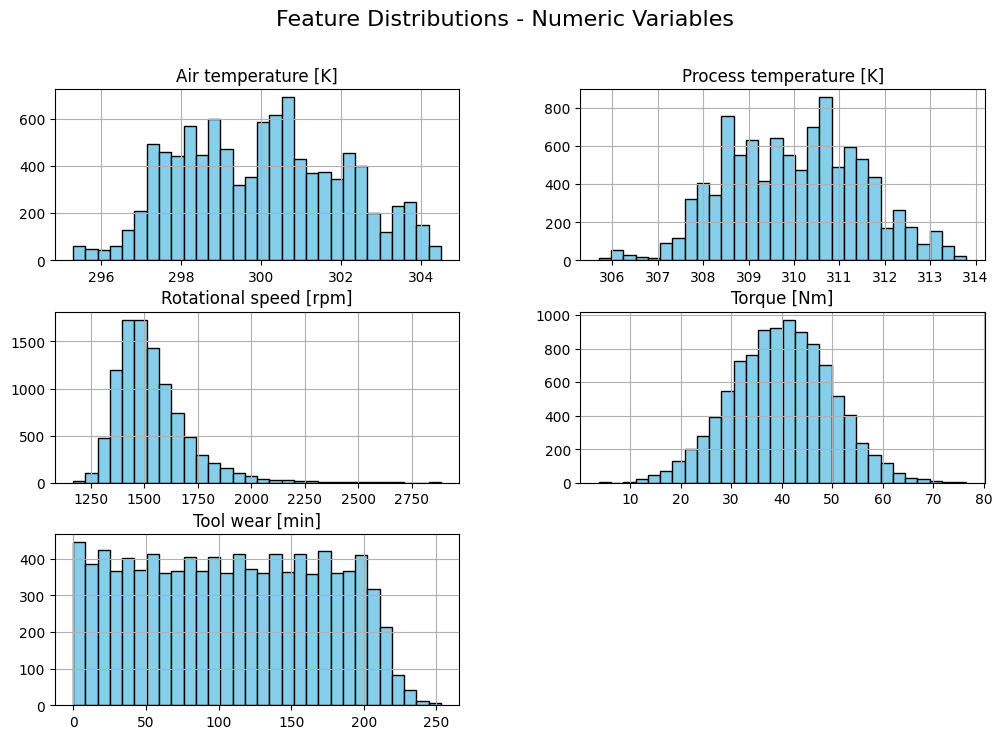

In [13]:
numeric_cols = ["Air temperature [K]", "Process temperature [K]", 
                "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

# Histograms for numeric features
df[numeric_cols].hist(bins=30, figsize=(12,8), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions - Numeric Variables", fontsize=16)
plt.show()


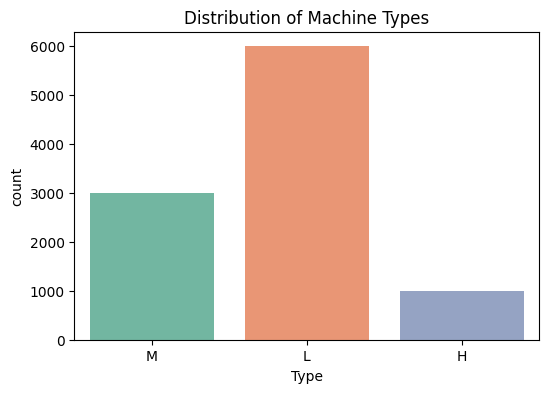

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x="Type", hue="Type", data=df, palette="Set2", legend=False)
plt.title("Distribution of Machine Types")
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_5944\3153098031.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Machine failure", y="Torque [Nm]", data=df, palette="Set2")


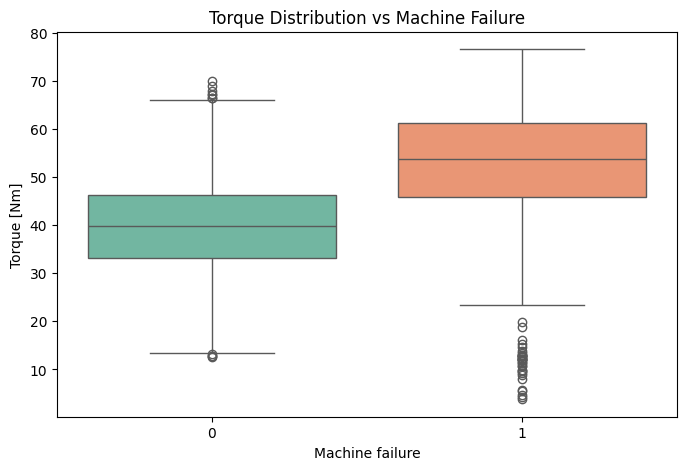

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Machine failure", y="Torque [Nm]", data=df, palette="Set2")
plt.title("Torque Distribution vs Machine Failure")
plt.show()


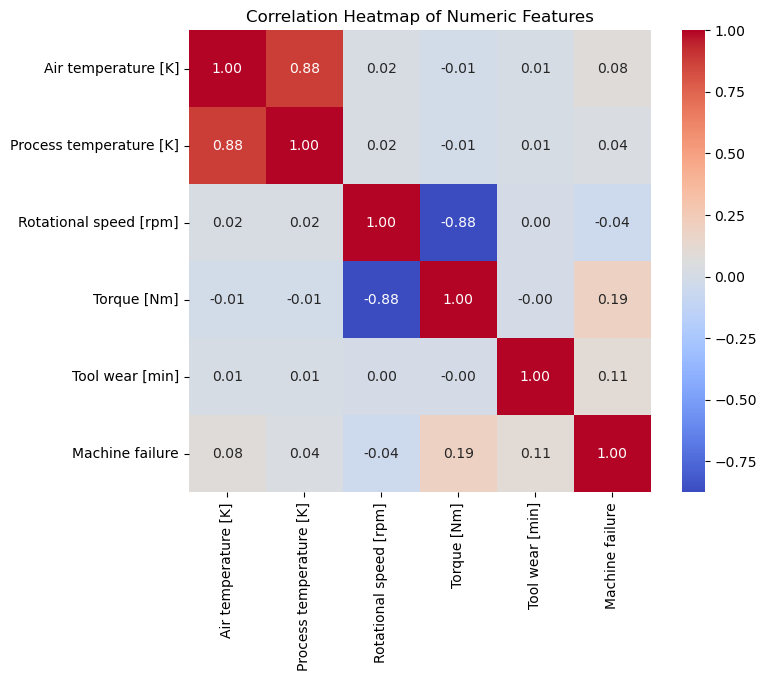

In [5]:

# Select numeric columns only
numeric_cols = ["Air temperature [K]", "Process temperature [K]", 
                "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]", "Machine failure"]

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

**Checking for Null data set**

In [21]:
 print(df.isnull().values.any())

False


**Extracting Independent Varibales**

In [24]:
X = df.drop(['UDI','Product ID','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis='columns').values
X

array([['M', 298.1, 308.6, 1551, 42.8, 0],
       ['L', 298.2, 308.7, 1408, 46.3, 3],
       ['L', 298.1, 308.5, 1498, 49.4, 5],
       ...,
       ['M', 299.0, 308.6, 1645, 33.4, 22],
       ['H', 299.0, 308.7, 1408, 48.5, 25],
       ['M', 299.0, 308.7, 1500, 40.2, 30]], dtype=object)

**Extracting Dependent variable**

In [17]:
y=df['Machine failure'].values
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Encoding Categorical Data

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers = [('Encode',OneHotEncoder(),[0])], remainder = 'passthrough')

In [29]:
X = np.array(ct.fit_transform(X))
X

array([[0.0, 0.0, 1.0, ..., 1551, 42.8, 0],
       [0.0, 1.0, 0.0, ..., 1408, 46.3, 3],
       [0.0, 1.0, 0.0, ..., 1498, 49.4, 5],
       ...,
       [0.0, 0.0, 1.0, ..., 1645, 33.4, 22],
       [1.0, 0.0, 0.0, ..., 1408, 48.5, 25],
       [0.0, 0.0, 1.0, ..., 1500, 40.2, 30]], dtype=object)

In [ ]:
print(X.shape)

### Spliting Dataset into Training and Test set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Feature Scaling

In [36]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:,3:] = sc.fit_transform(X_train[:,3:])
X_test[:,3:] = sc.transform(X_test[:,3:])

In [37]:
print(X_train)

[[0.0 1.0 0.0 ... 0.4276341765988049 -0.8926964372001142
  1.3750353850894999]
 [0.0 1.0 0.0 ... -0.8349445732230913 1.3821872742036723
  0.45762015943484763]
 [0.0 1.0 0.0 ... -0.05967691982368137 -0.8926964372001142
  1.3592178811989024]
 ...
 [1.0 0.0 0.0 ... -0.3088700941306346 0.7207673404915586
  1.8179254940262284]
 [1.0 0.0 0.0 ... 0.012312219420549561 -0.7423737249928155
  -1.1874002451872874]
 [0.0 1.0 0.0 ... 1.4908583869751386 -1.4238366869992363
  -1.1557652374060925]]


In [38]:
print(X_test)

[[0.0 1.0 0.0 ... -0.004300658866580653 -0.3916207298424519
  1.4224878967612922]
 [0.0 0.0 1.0 ... -0.652202912064659 0.4802510009598801
  -0.11180998062666064]
 [0.0 0.0 1.0 ... -0.29779484193921446 0.19964860483958952
  0.14127008162289859]
 ...
 [0.0 1.0 0.0 ... -1.2281160260185064 1.6527681561768102
  -1.598655346342821]
 [0.0 1.0 0.0 ... 6.546711012358434 -3.077386521279522
  -1.4246628035462492]
 [0.0 0.0 1.0 ... -1.3167180435498675 1.5024454439695116
  -1.5670203385616261]]
